**Выполнил:** Максим Еремеев

https://github.com/dashapopova/CompSem2024/blob/main/HW/HW2.md



## Вводная часть

1. Взять любую предобученную векторную модель для русского языка и извлечь оттуда вектор для каждого глагола и каждого существительного из списка.

In [1]:
with open('HW2_change.txt', 'r') as f:
  data = f.read()

In [2]:
# превращаем прочитанные данные в список кортежей
data_tuples = [tuple(pair.split('\t')) for pair in data.split('\n')[:-1]]

In [3]:
data_tuples[:5]

[('сменить', 'гнев'),
 ('сменить', 'пост'),
 ('сменить', 'милость'),
 ('сменить', 'тактика'),
 ('сменить', 'тема')]

In [4]:
import sys
import gensim, logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [5]:
# импортируем библиотеки Word2Vec
from gensim.models.word2vec import Word2Vec # собственно модель
from gensim.models import KeyedVectors # семантические вектора

import numpy as np

In [6]:
! pip install wget -q

  Preparing metadata (setup.py) ... done


In [7]:
import zipfile
import wget

In [8]:
model_url = 'http://vectors.nlpl.eu/repository/20/220.zip'
m = wget.download(model_url)
model_file = model_url.split('/')[-1]

with zipfile.ZipFile(model_file, 'r') as archive:
    archive.extractall()  # извлекаем все файлы в текущую директорию

# загружаем модель из извлеченного файла model.bin
model_path = 'model.bin'
model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

2. На основе этих векторов построить репрезентацию для каждой пары «глагол + существительное» с помощью простой аддитивной модели композиции.

In [118]:
# создаём пустые списки для сумм векторов и биграмм
sum_vectors = []
bigrams = []

# циклом проходимся по списку кортежей
for pair in data_tuples:
  # добавляем словам в кортежам pos-теги
  verb = f'{pair[0]}_VERB'
  noun = f'{pair[1]}_NOUN'

  # проверяем, что оба слова есть в модели
  if noun in model and verb in model:
    # находим вектора
    verb_vec = model[verb]
    noun_vec = model[noun]
    # их сумму добавляем в словарь сумм вектором
    sum_vectors.append(verb_vec + noun_vec)
    # а сами слова через нижнее подчёркивание в словарь биграмм
    bigrams.append('_'.join(pair))

In [152]:
# создаём словарь вида биграмма : её вектор
bigram_to_vector = dict(zip(bigrams, sum_vectors))

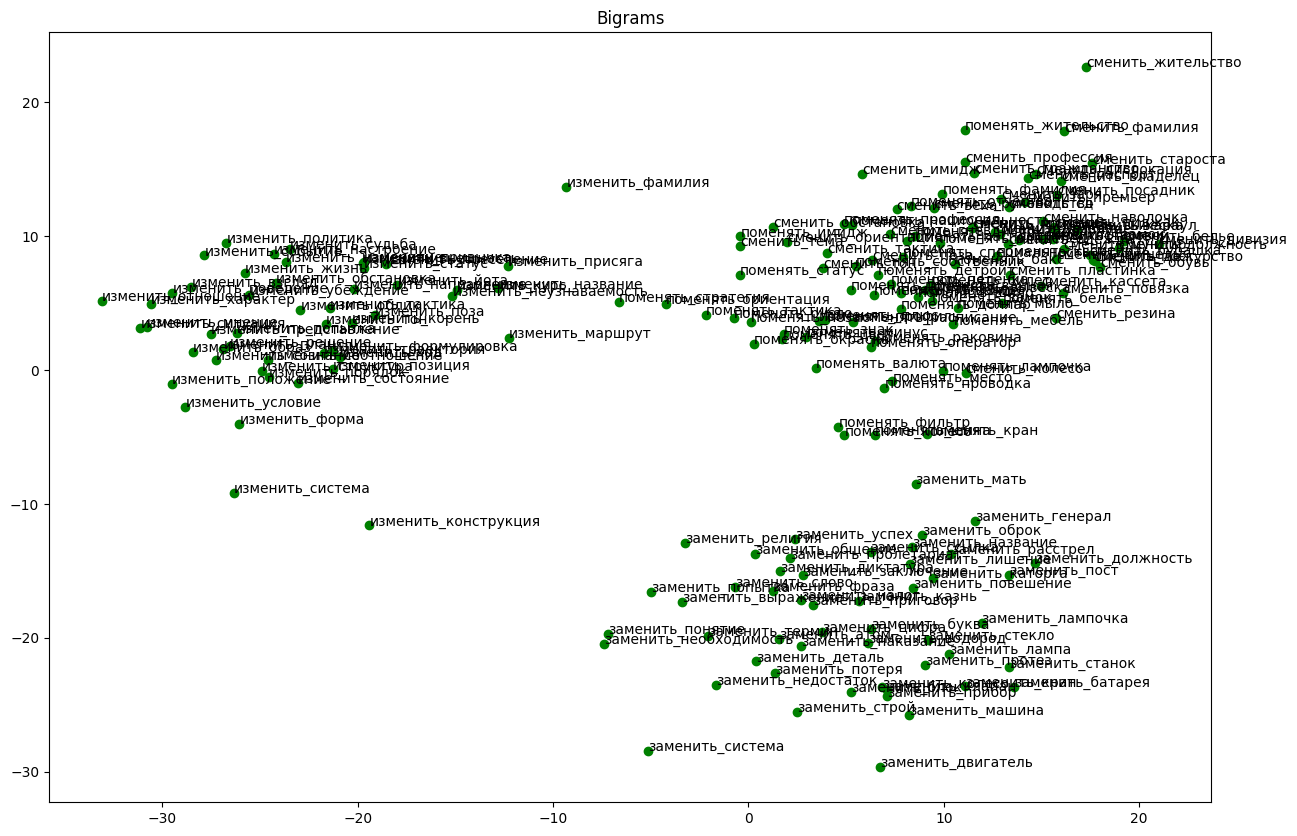

In [193]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

# посмотрим на представление векторов в двумерном пространстве c помощью PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(sum_vectors)

plt.figure(figsize=(15, 10))
plt.scatter(coords[:, 0], coords[:, 1], color='green')
plt.title('Bigrams')

for i, bigram in enumerate(bigrams):
    plt.annotate(bigram, xy=(coords[i, 0], coords[i, 1]))

plt.show()

In [213]:
# посмотрим на размерность массива
X = np.array(sum_vectors)
X.shape # 198 - количество биграмм, 300 - длина векторов

(198, 300)

3. Собрать все векторные представления пар в единую матрицу и кластеризовать их двумя способами:
* методом иерархической кластеризации;
* методом К-средних.

4. Для каждого кластера определите центр и выберите по три элемента, наиболее к нему близких (по метрике косинусной близости). Центр можно определить как среднее арифметическое среди всех элементов кластера по каждому измерению (например, с помощью метода numpy.mean).
Кластеры, размер которых не превышает двух элементов, не учитывайте совсем.

5. Оформите результат в виде набора групп из трех словосочетаний, например:
идти_дождь, идти_снег, идти_град
идти_часы, идти_время, идти_урок
…

## Метод иерархической кластеризации

In [21]:
import scipy
import scipy.cluster.hierarchy as hcluster

1.154 - пороговое значение со сравнительно небольшим количеством знаков после запятой, которое позволяет добиться выделения 70 кластеров

1.155 - выделяется уже 1 кластер

1.1546 - выделяется 17 кластеров; казалось бы, лучше и нагляднее, но если оставляем только кластеры с количество элементов >2, то остаётся всего два кластера, что непоказательно

In [155]:
Z = hcluster.linkage(X)

threshold = 1.154 # 70 кластеров

clusters = hcluster.fcluster(Z, threshold)
print('Количество кластеров: ', len(set(clusters)))

Количество кластеров:  70


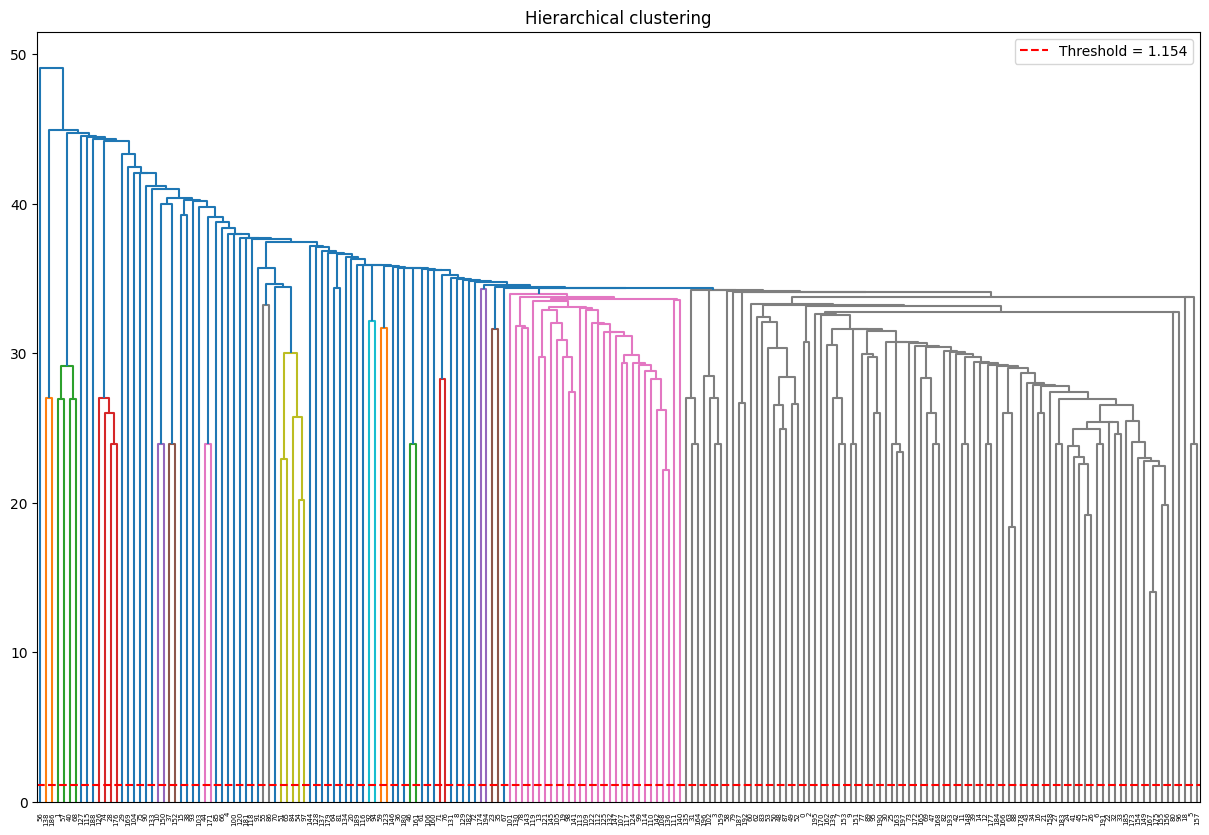

In [192]:
# посмотрим на дендрограмме

plt.figure(figsize=(15, 10))
dn = hcluster.dendrogram(Z)

plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.legend()

plt.title('Hierarchical clustering')
plt.show()

In [254]:
from collections import defaultdict

# создаём словарь, в котором будем хранить данные вида номер кластера : биграммы
hierarchy_clustered_bigrams = defaultdict(list)
for bigram, label in zip(bigrams, clusters):
    hierarchy_clustered_bigrams[label].append(bigram)

# посмотрим на кластеры с числом элементов 3 и более
for cluster, bigrams_in_cluster in hierarchy_clustered_bigrams.items():
    if len(bigrams_in_cluster) > 2:
        print(f"Кластер {cluster}: {len(bigrams_in_cluster), bigrams_in_cluster}")

Кластер 31: (88, ['сменить_гнев', 'сменить_милость', 'сменить_тактика', 'сменить_профессия', 'сменить_белье', 'сменить_фамилия', 'сменить_имидж', 'сменить_ориентация', 'сменить_вывеска', 'сменить_пластинка', 'сменить_караул', 'сменить_рубашка', 'сменить_амплуа', 'сменить_часовой', 'сменить_обувь', 'сменить_мундир', 'сменить_владелец', 'сменить_пиджак', 'сменить_прическа', 'сменить_дежурство', 'сменить_поза', 'сменить_одежда', 'сменить_костюм', 'сменить_резина', 'сменить_заря', 'сменить_наволочка', 'сменить_повязка', 'сменить_кассета', 'сменить_шинель', 'сменить_колесо', 'заменить_казнь', 'заменить_каторга', 'заменить_расстрел', 'заменить_ссылка', 'заменить_приговор', 'заменить_наказание', 'заменить_заключение', 'заменить_налог', 'заменить_лампа', 'заменить_колесо', 'заменить_стекло', 'заменить_машина', 'заменить_деталь', 'заменить_клапан', 'заменить_прибор', 'заменить_оброк', 'заменить_повешение', 'заменить_лампочка', 'заменить_станок', 'заменить_кран', 'заменить_протез', 'изменить_так

In [158]:
from sklearn.metrics.pairwise import cosine_similarity

# функция по поиску центрального элемента кластера и двух ближайших к нему элементов
def find_centrals(bigram_to_vector, clustered_bigrams):
    for cluster, bigrams_in_cluster in clustered_bigrams.items():
        if len(bigrams_in_cluster) > 2:

            # получение векторов для всех биграм в кластере
            vectors = np.array([bigram_to_vector[bigram] for bigram in bigrams_in_cluster])

            # вычисление косинусного сходства между всеми парами
            similarity_matrix = cosine_similarity(vectors)

            # определение центрального элемента (с минимальным средним расстоянием к другим)
            avg_distances = 1 - np.mean(similarity_matrix, axis=1)
            central_index = np.argmin(avg_distances)
            central_bigram = bigrams_in_cluster[central_index]

            # нахождение двух ближайших элементов по косинусной близости
            similarities_to_central = similarity_matrix[central_index]
            closest_indices = np.argsort(-similarities_to_central)[1:3]  # отсортировать и взять 2 индекса (без самого себя)
            closest_bigrams = [bigrams_in_cluster[i] for i in closest_indices]

            print(f"Кластер {cluster}:")
            print(central_bigram, '\t', *closest_bigrams)

In [246]:
find_centrals(bigram_to_vector, hierarchy_clustered_bigrams)

Кластер 31:
сменить_наволочка 	 сменить_рубашка сменить_белье
Кластер 18:
изменить_обстановка 	 изменить_ситуация сменить_обстановка
Кластер 4:
поменять_название 	 сменить_название заменить_название
Кластер 9:
заменить_слово 	 заменить_фраза заменить_выражение
Кластер 17:
изменить_система 	 заменить_система изменить_структура
Кластер 20:
изменить_йота 	 изменить_неузнаваемость изменить_формулировка


## Метод K средних

In [35]:
from sklearn.cluster import KMeans

На графике из вводной части видно три чётких кластера (напоминает трёхлистный клевер). Посмотрим, как биграммы распределятся по трём кластерам с помощью KMeans

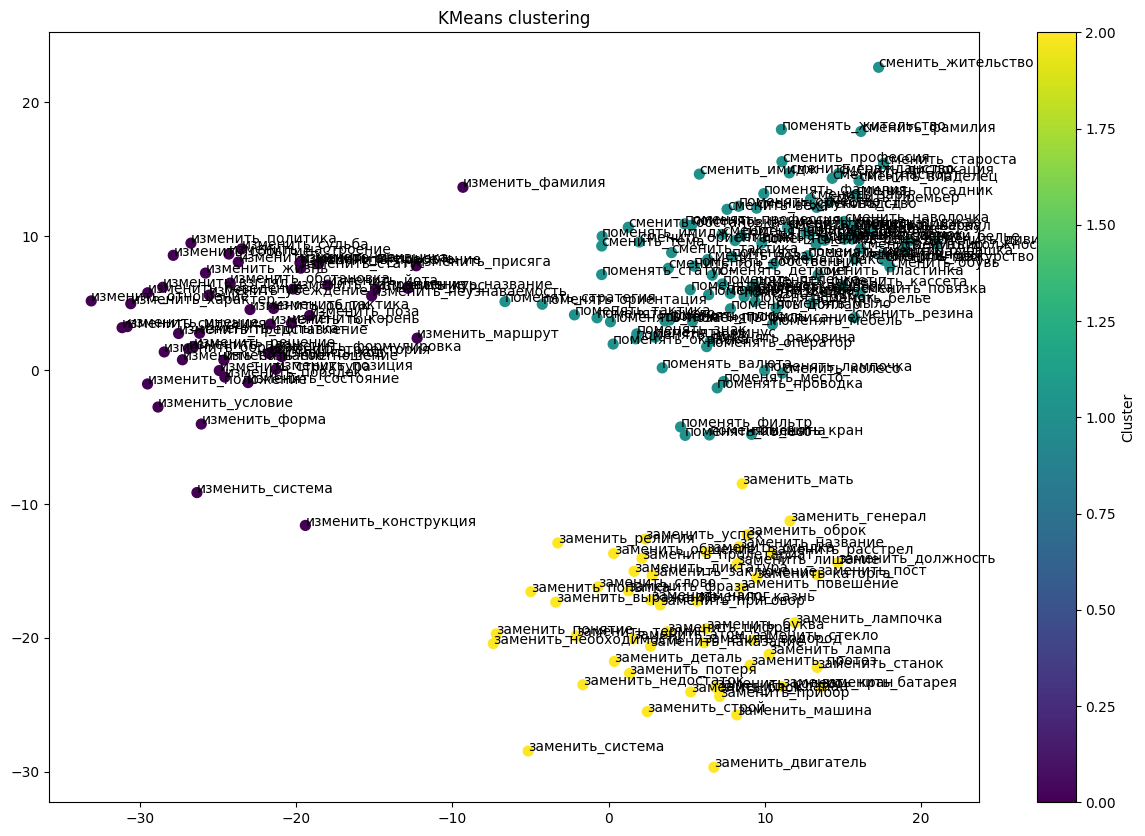

In [241]:
number_of_clusters = 3

kmeans = KMeans(n_clusters=number_of_clusters).fit(X)
kmeans_clusters = kmeans.labels_

# также представляем с помощью PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(sum_vectors)

plt.figure(figsize=(15, 10))
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=kmeans_clusters, cmap='viridis', s=50)
plt.colorbar(scatter, label='Cluster')

for i, bigram in enumerate(bigrams):
    plt.annotate(bigram, xy=(coords[i, 0], coords[i, 1]))

plt.title('KMeans clustering')
plt.show()

Действительно, получившиеся кластеры соответствуют "лепесткам" клевера

Методом иерархической кластеризации выделилось 6 кластеров. Было бы интересно посмотреть, на какие 6 кластеров поделит биграммы метод K средних и будут ли совпадать кластеры, полученные этими двумя методами

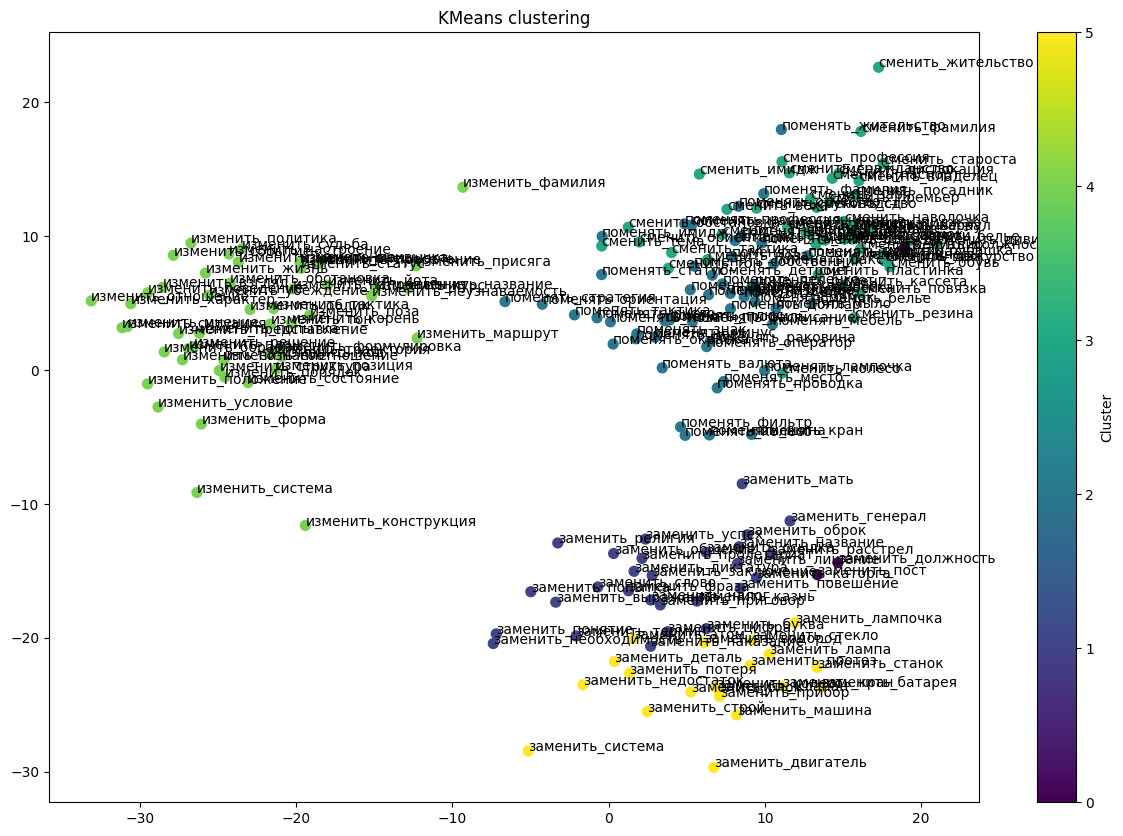

In [243]:
number_of_clusters = 6

kmeans = KMeans(n_clusters=number_of_clusters).fit(X)
kmeans_clusters = kmeans.labels_

plt.figure(figsize=(15, 10))
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=kmeans_clusters, cmap='viridis', s=50)
plt.colorbar(scatter, label='Cluster')

for i, bigram in enumerate(bigrams):
    plt.annotate(bigram, xy=(coords[i, 0], coords[i, 1]))

plt.title('KMeans clustering')
plt.show()

In [253]:
from collections import defaultdict

# создаём словарь с данными вида номер кластера : биграммы
kmeans_clustered_bigrams = defaultdict(list)
for bigram, label in zip(bigrams, kmeans_clusters):
    kmeans_clustered_bigrams[label].append(bigram)

# посмотрим на кластеры с числом элементов 3 и более
for cluster, bigrams_in_cluster in kmeans_clustered_bigrams.items():
    if len(bigrams_in_cluster) > 2:
        print(f"Кластер {cluster}: {len(bigrams_in_cluster), bigrams_in_cluster}")

Кластер 3: (46, ['сменить_гнев', 'сменить_милость', 'сменить_тактика', 'сменить_тема', 'сменить_профессия', 'сменить_белье', 'сменить_фамилия', 'сменить_веха', 'сменить_имидж', 'сменить_жительство', 'сменить_ориентация', 'сменить_вывеска', 'сменить_тон', 'сменить_пластинка', 'сменить_сд', 'сменить_караул', 'сменить_рубашка', 'сменить_амплуа', 'сменить_обстановка', 'сменить_гражданство', 'сменить_часовой', 'сменить_обувь', 'сменить_посадник', 'сменить_мундир', 'сменить_владелец', 'сменить_пиджак', 'сменить_прическа', 'сменить_название', 'сменить_премьер', 'сменить_дежурство', 'сменить_поза', 'сменить_одежда', 'сменить_костюм', 'сменить_резина', 'сменить_староста', 'сменить_руководство', 'сменить_дислокация', 'сменить_дивизия', 'сменить_заря', 'сменить_наволочка', 'сменить_повязка', 'сменить_кассета', 'сменить_замок', 'сменить_шинель', 'сменить_паспорт', 'сменить_колесо'])
Кластер 0: (4, ['сменить_пост', 'сменить_должность', 'заменить_пост', 'заменить_должность'])
Кластер 1: (28, ['замен

In [245]:
find_centrals(bigram_to_vector, kmeans_clustered_bigrams)

Кластер 3:
сменить_наволочка 	 сменить_рубашка сменить_белье
Кластер 0:
сменить_должность 	 заменить_должность сменить_пост
Кластер 1:
заменить_повешение 	 заменить_казнь заменить_расстрел
Кластер 5:
заменить_прибор 	 заменить_лампа заменить_машина
Кластер 4:
изменить_йота 	 изменить_неузнаваемость изменить_формулировка
Кластер 2:
поменять_детройт 	 поменять_бакс поменять_шило


## Анализ результатов

6. Подготовьте очень краткий (буквально на абзац) анализ результатов. Однородные ли, на ваш взгляд, получились группы? Получается ли выявить сходства и различия в семантике глаголов?

Ниже представлено по 6 кластеров, полученных двумя методами: Hierarchical clustering и KMeans. Жирным выделены центральные элементы кластеров, совпадающие у обоих методов

Кластеры 31 и 3, судя по центральным элементам, связаны с заменой предметов ('сменить_наволочка'). На самом деле, оба кластера включают не только предметы  (например, и там, и там есть 'сменить_гнев')

Кластеры 20 и 4, судя по центральным элементам, связаны с изменением абстрактных понятий ('изменить_формулировка'). При этом 'изменить_тактика' по иерархической кластеризации отнесён к кластеру с ядерной семантикой замены предметов, а по KMeans - к кластеру с ядерной семантикой замены абстрактных понятий

Hierarchical clustering


---


**Кластер 31:**

* **сменить_наволочка**
* **сменить_рубашка**
* **сменить_белье**

Кластер 18:

* изменить_обстановка
* изменить_ситуация
* сменить_обстановка

Кластер 4:
* поменять_название
* сменить_название
* заменить_название

Кластер 9:
* заменить_слово
* заменить_фраза
* заменить_выражение

Кластер 17:
* изменить_система
* заменить_система
* изменить_структура

**Кластер 20:**
* **изменить_йота**
* **изменить_неузнаваемость**
* **изменить_формулировка**

Ядерная семантика кластера 31 - замена предмета, хотя в целом в кластер входит и абстрактное. Этот кластер самый длинный (88 элементов, тогда как у остальных количество элементов не превышает 10). Кажется, что этот кластер вобрал в себя слишком много всего, стал такой "мусоркой" для биграмм, не подходящих под остальные кластеры. Вероятно, это говорит о том, что t-value стоило сделать пониже

Кластер 18 - про изменение абстрактного, связанного с семантикой ситуаций и отношения

Кластер 4 - про смену названия. Всего 4 элемента, везде существительное 'название'

Кластер 9 - семантика связана с языком и языковыми единицами, везде глагол 'заменить'

Кластер 17 - про изменение системы, всего 3 элемента

Кластер 20 - изменение абстрактного, везде глагол 'изменить'

Суммаризуя:

1. КЛАСТЕР 4: СМЕНА НАЗВАНИЯ
2. КЛАСТЕР 9: СМЕНА НЕКОЙ ЕДИНИЦЫ ЯЗЫКА
3. КЛАСТЕР 17: ИЗМЕНЕНИЕ СИСТЕМЫ
4. КЛАСТЕР 18: ИЗМЕНЕНИЕ СИТУАЦИИ И ОТНОШЕНИЯ
5. КЛАСТЕР 20: 'ИЗМЕНИТЬ' + АБСТРАКТНОЕ
6. КЛАСТЕР 31: ЗАМЕНА ПРЕДМЕТА / АБСТРАКТНОГО



KMeans


---



**Кластер 3:**

* **сменить_наволочка**
* **сменить_рубашка**
* **сменить_белье**

Кластер 0:

* сменить_должность
* заменить_должность
* сменить_пост

Кластер 1:

* заменить_повешение
* заменить_казнь
* заменить_расстрел

Кластер 5:

* заменить_прибор
* заменить_лампа
* заменить_машина

**Кластер 4:**

* **изменить_йота**
* **изменить_неузнаваемость**
* **изменить_формулировка**

Кластер 2:
* поменять_детройт
* поменять_бакс
* поменять_шило

Ядерная семантика кластера 3 - замена предметов, но есть и абстрактные существительные (тот же 'сменить гнев'). Представлены биграммы только одного глагола - 'сменить'

Кластер 0 представлен всего 4 биграммами и связан со сменой поста или должности

Ядерная семантика кластера 1 - замена меры наказания, однако к нему относится ещё много чего ('заменить_мать', 'заменить_фраза', 'заменить_успех'). Заметим, что в этом кластере представлены только биграммы глагола 'заменить' - возможно, он как раз и выражает специфичное значение этого глагола. Биграммы, слабо семантически связанные с ядерным значением, свидетельствуют о том, что количество кластеров можно было бы увеличить.

Кластер 5 связан с заменой приборов и функциональных предметов, только биграммы глагола 'заменить'

Кластер 4 - только биграммы глагола 'изменить'

Основания для выделения кластера 2 из центральных элементов не очень ясны. Там присутствуют как предметы ('поменять_билет'), так и абстрактные понятия ('поменять_отчество'). Тут, как и в кластерах 1, 3, 4 и 5, представлены биграммы только одного глагола, в данном случае 'поменять'

Суммаризуя:

1. КЛАСТЕР 0: СМЕНА ПОСТА ИЛИ ДОЛЖНОСТИ

2. КЛАСТЕР 1: 'ЗАМЕНИТЬ' + АБСТРАКТНОЕ

3. КЛАСТЕР 2: 'ПОМЕНЯТЬ'

4. КЛАСТЕР 3: 'СМЕНИТЬ'

5. КЛАСТЕР 4: 'ИЗМЕНИТЬ'

6. КЛАСТЕР 5: 'ЗАМЕНИТЬ' + ПРЕДМЕТЫ

**Вывод:** группы, выявленные по KMeans, получились более однородными (стандартное отклонение почти вдвое меньше, чем у hierarchical). С методом KMeans получился только один кластер с конкретной семантикой (смена поста или должности), все остальные - более общие, опирающиеся в основном на семантику глагола. С методом Hierarchical clustering, напротив, получилось выделить 5 в достаточной степени конкретных кластеров, однако в шестом кластере собрались все остальные биграммы, не всегда семантически связанные друг с другом, которые слились в один кластер из-за высокого порогового значения

Особых выводов о разнице в семантике глаголов сделать не получается. Можно заметить, что в кластерах KMeans выделяется два значения для 'заменить' - заменить предмет и заменить нечто абстрактное

## Свой датасет

7. (бонус на 10). Вместо предложенного датасета возьмите свой: выберите несколько предикатов и по любому корпусу составьте список существительных - их наиболее частотных аргументов (в списке должно быть 100-200 словосочетаний). Максимально четко опишите процедуру подготовки датасета: какой использовался корпус, как был составлен сам список.



Я решил рассмотреть коллокации глагола 'любить'. Возьму его и четыре глагола, близких по векторам: пускай это будут 'обожать', 'ненавидеть' и 'уважать'

![img](https://imgur.com/likwY9q.png)

К каждому слову найдём 25 коллокаций в основном корпусе НКРЯ по запросам вида:

КЛЮЧ: лемма ИНФИНИТИВ ГЛАГОЛА

КОЛЛОКАТ: грамматические признаки (S) & (acc)

Затем из списка коллокатов с каждым из глаголов берём 30 самых частотных и собираем в один файл с названием, отсылающим к песне Pet Shop Boys



In [263]:
with open('love_etc_collocations.txt', 'r') as f:
  data = f.read()

In [264]:
data_tuples = [tuple(pair.split('\t')) for pair in data.split('\n')[:-1]]

In [265]:
sum_vectors = []
bigrams = []

for pair in data_tuples:
  verb = f'{pair[0]}_VERB'
  noun = f'{pair[1]}_NOUN'

  if noun in model and verb in model:
    verb_vec = model[verb]
    noun_vec = model[noun]
    sum_vectors.append(verb_vec + noun_vec)
    bigrams.append('_'.join(pair))

bigram_to_vector = dict(zip(bigrams, sum_vectors))

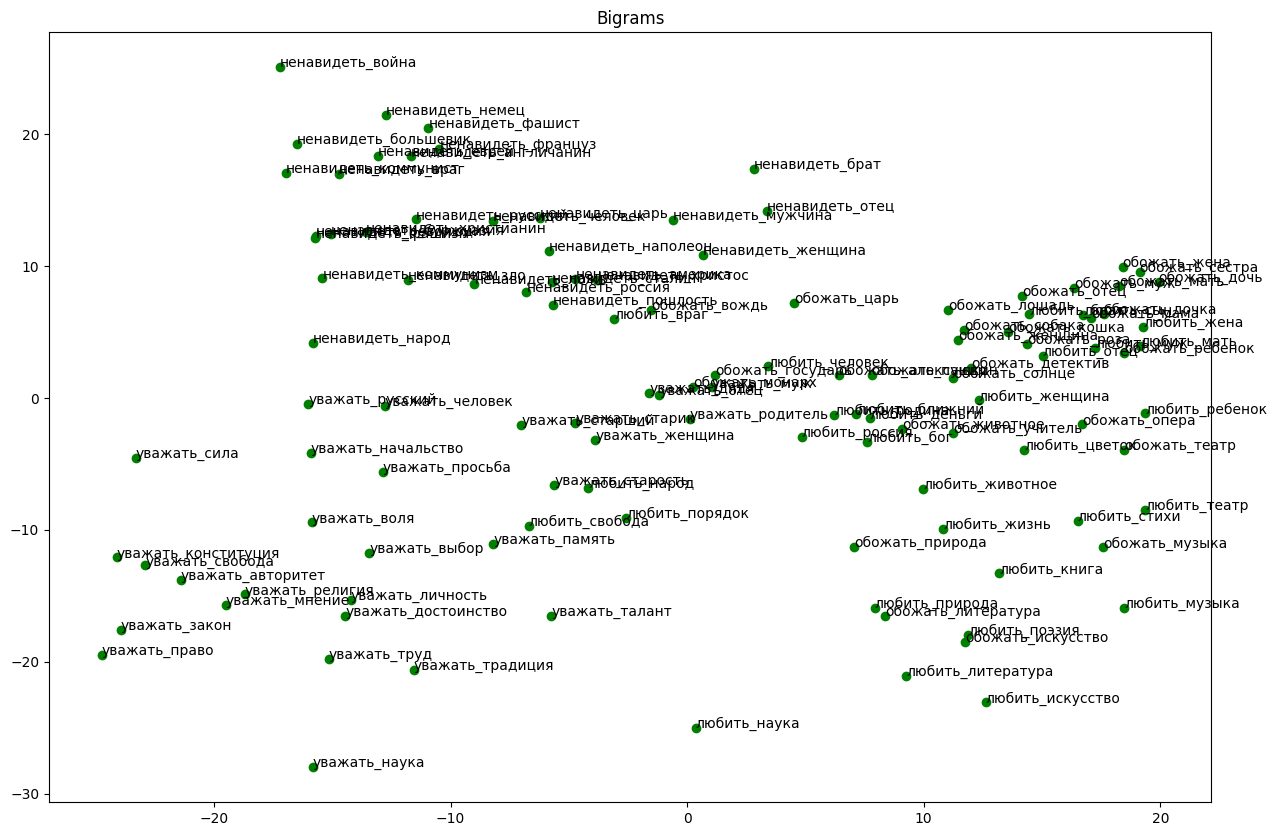

In [266]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

# посмотрим на представление векторов в двумерном пространстве c помощью PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(sum_vectors)

plt.figure(figsize=(15, 10))
plt.scatter(coords[:, 0], coords[:, 1], color='green')
plt.title('Bigrams')

for i, bigram in enumerate(bigrams):
    plt.annotate(bigram, xy=(coords[i, 0], coords[i, 1]))

plt.show()

In [267]:
X = np.array(sum_vectors)
X.shape

(119, 300)

In [279]:
Z = hcluster.linkage(X)

threshold = 1 # наученные опытом, оставим пороговое значение поменьше

clusters = hcluster.fcluster(Z, threshold)
print('Количество кластеров: ', len(set(clusters)))

Количество кластеров:  70


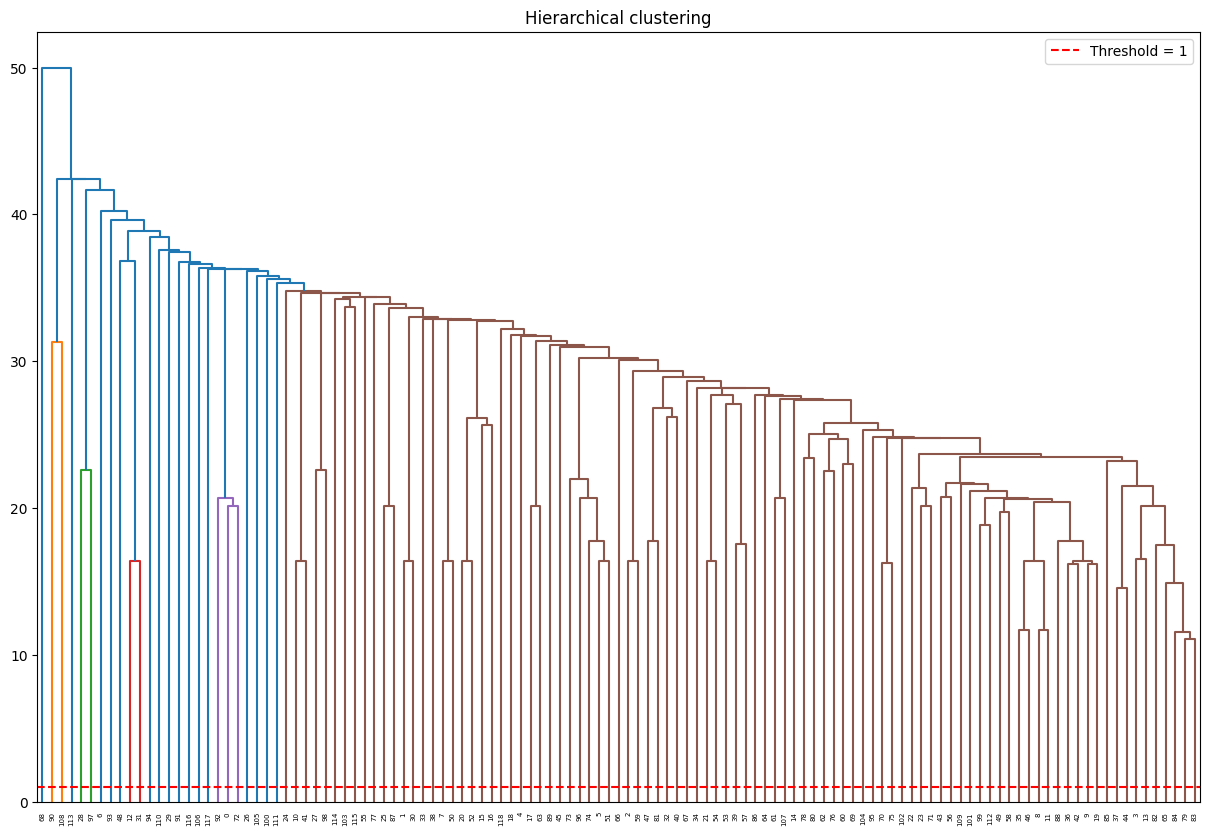

In [280]:
plt.figure(figsize=(15, 10))
dn = hcluster.dendrogram(Z)

plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.legend()

plt.title('Hierarchical clustering')
plt.show()

In [281]:
from collections import defaultdict

# создаём словарь, в котором будем хранить данные вида номер кластера : биграммы
hierarchy_clustered_bigrams = defaultdict(list)
for bigram, label in zip(bigrams, clusters):
    hierarchy_clustered_bigrams[label].append(bigram)

# посмотрим на кластеры с числом элементов 3 и более
for cluster, bigrams_in_cluster in hierarchy_clustered_bigrams.items():
    if len(bigrams_in_cluster) > 2:
        print(f"Кластер {cluster}: {len(bigrams_in_cluster), bigrams_in_cluster}")

Кластер 4: (3, ['любить_человек', 'ненавидеть_человек', 'уважать_человек'])
Кластер 13: (5, ['любить_женщина', 'обожать_женщина', 'ненавидеть_мужчина', 'ненавидеть_женщина', 'уважать_женщина'])
Кластер 3: (3, ['любить_театр', 'обожать_театр', 'обожать_опера'])
Кластер 11: (4, ['любить_стихи', 'любить_поэзия', 'любить_литература', 'обожать_литература'])
Кластер 16: (5, ['любить_животное', 'обожать_кошка', 'обожать_лошадь', 'обожать_животное', 'обожать_собака'])
Кластер 22: (3, ['любить_сын', 'любить_брат', 'ненавидеть_брат'])
Кластер 15: (4, ['обожать_государь', 'обожать_монарх', 'обожать_царь', 'ненавидеть_царь'])
Кластер 35: (5, ['ненавидеть_россия', 'ненавидеть_сталин', 'ненавидеть_наполеон', 'ненавидеть_америка', 'ненавидеть_христос'])
Кластер 7: (3, ['уважать_личность', 'уважать_воля', 'уважать_религия'])


In [282]:
find_centrals(bigram_to_vector, hierarchy_clustered_bigrams)

Кластер 4:
ненавидеть_человек 	 любить_человек уважать_человек
Кластер 13:
ненавидеть_женщина 	 обожать_женщина любить_женщина
Кластер 3:
обожать_театр 	 любить_театр обожать_опера
Кластер 11:
любить_литература 	 обожать_литература любить_поэзия
Кластер 16:
обожать_собака 	 обожать_кошка обожать_животное
Кластер 22:
любить_брат 	 ненавидеть_брат любить_сын
Кластер 15:
обожать_царь 	 ненавидеть_царь обожать_государь
Кластер 35:
ненавидеть_сталин 	 ненавидеть_америка ненавидеть_христос
Кластер 7:
уважать_личность 	 уважать_религия уважать_воля


КЛАСТЕР ОТНОШЕНИЯ К ЧЕЛОВЕКУ В ЦЕЛОМ: ненавидеть_человек 	 любить_человек уважать_человек

КЛАСТЕР ОТНОШЕНИЯ К ЖЕНЩИНЕ (И МУЖЧИНЕ): ненавидеть_женщина 	 обожать_женщина любить_женщина

КЛАСТЕР ЛЮБВИ К ТЕАТРУ: обожать_театр 	 любить_театр обожать_опера

КЛАСТЕР ЛЮБВИ К ЛИТЕРАТУРЕ: любить_литература 	 обожать_литература любить_поэзия

КЛАСТЕР ЛЮБВИ К ЖИВОТНЫМ: обожать_собака 	 обожать_кошка обожать_животное

КЛАСТЕР ОТНОШЕНИЯ К РОДСТВЕННИКАМ: любить_брат 	 ненавидеть_брат любить_сын

КЛАСТЕР ОТНОШЕНИЯ К ПРАВИТЕЛЯМ: обожать_царь 	 ненавидеть_царь обожать_государь

КЛАСТЕР НЕНАВИСТИ К АВТОРИТЕТАМ: ненавидеть_сталин 	 ненавидеть_америка ненавидеть_христос

КЛАСТЕР ТОЛЕРАНТНОСТИ: уважать_личность 	 уважать_религия уважать_воля

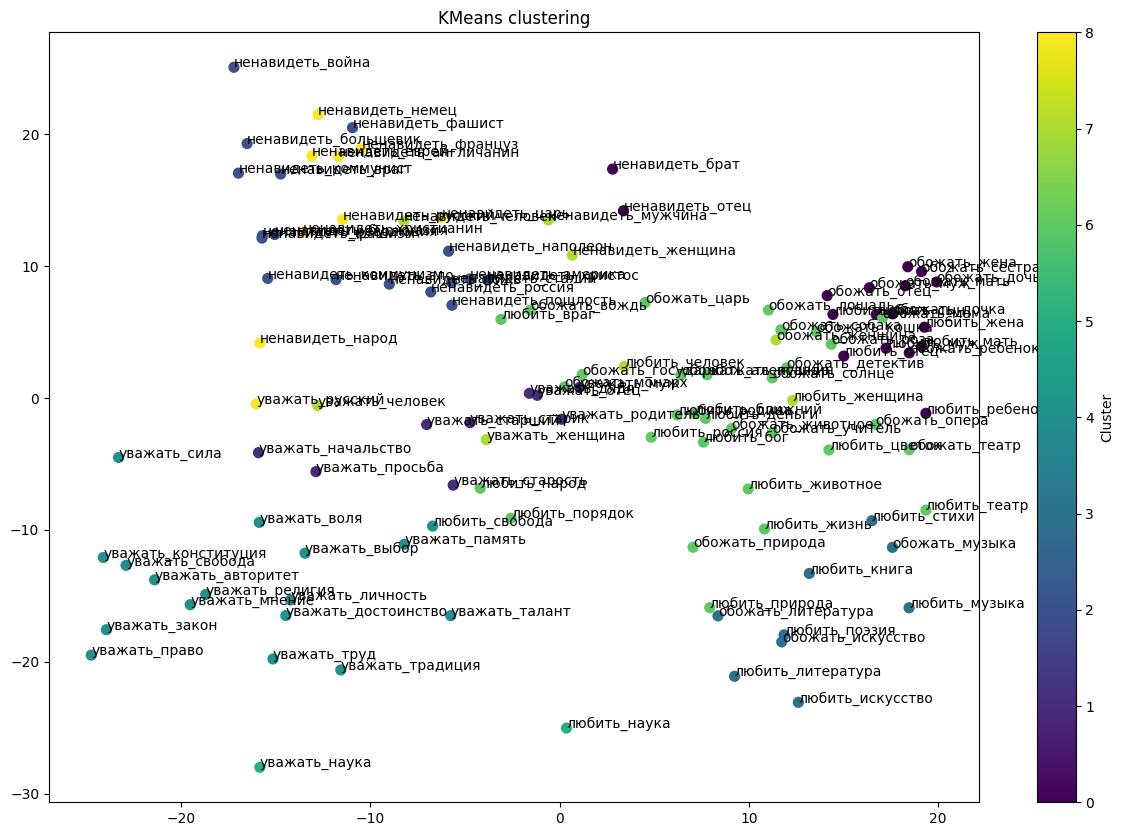

In [286]:
number_of_clusters = 9

kmeans = KMeans(n_clusters=number_of_clusters).fit(X)
kmeans_clusters = kmeans.labels_

plt.figure(figsize=(15, 10))
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=kmeans_clusters, cmap='viridis', s=50)
plt.colorbar(scatter, label='Cluster')

for i, bigram in enumerate(bigrams):
    plt.annotate(bigram, xy=(coords[i, 0], coords[i, 1]))

plt.title('KMeans clustering')
plt.show()

In [284]:
from collections import defaultdict

# создаём словарь с данными вида номер кластера : биграммы
kmeans_clustered_bigrams = defaultdict(list)
for bigram, label in zip(bigrams, kmeans_clusters):
    kmeans_clustered_bigrams[label].append(bigram)

# посмотрим на кластеры с числом элементов 3 и более
for cluster, bigrams_in_cluster in kmeans_clustered_bigrams.items():
    if len(bigrams_in_cluster) > 2:
        print(f"Кластер {cluster}: {len(bigrams_in_cluster), bigrams_in_cluster}")

Кластер 7: (8, ['любить_человек', 'любить_женщина', 'обожать_женщина', 'ненавидеть_человек', 'ненавидеть_мужчина', 'ненавидеть_женщина', 'уважать_человек', 'уважать_женщина'])
Кластер 5: (10, ['любить_музыка', 'любить_жизнь', 'любить_искусство', 'любить_стихи', 'любить_поэзия', 'любить_литература', 'любить_книга', 'обожать_музыка', 'обожать_искусство', 'обожать_литература'])
Кластер 1: (31, ['любить_ребенок', 'любить_россия', 'любить_жена', 'любить_отец', 'любить_муж', 'любить_ближний', 'любить_родина', 'любить_мать', 'любить_сын', 'любить_брат', 'любить_деньги', 'обожать_детектив', 'обожать_роза', 'обожать_жена', 'обожать_мать', 'обожать_пушкин', 'обожать_учитель', 'обожать_кошка', 'обожать_отец', 'обожать_дочь', 'обожать_александр', 'обожать_муж', 'обожать_дочка', 'обожать_лошадь', 'обожать_сестра', 'обожать_собака', 'обожать_мама', 'обожать_ребенок', 'ненавидеть_брат', 'ненавидеть_отец', 'уважать_муж'])
Кластер 0: (8, ['любить_бог', 'любить_природа', 'любить_цветок', 'любить_животно

In [285]:
find_centrals(bigram_to_vector, kmeans_clustered_bigrams)

Кластер 7:
ненавидеть_женщина 	 обожать_женщина любить_женщина
Кластер 5:
любить_поэзия 	 любить_литература любить_стихи
Кластер 1:
любить_мать 	 любить_отец обожать_мать
Кластер 0:
любить_природа 	 обожать_природа любить_животное
Кластер 8:
обожать_театр 	 любить_театр обожать_опера
Кластер 3:
ненавидеть_сталин 	 ненавидеть_америка ненавидеть_христос
Кластер 6:
уважать_воля 	 уважать_свобода уважать_личность
Кластер 4:
уважать_наука 	 любить_наука уважать_труд
Кластер 2:
обожать_царь 	 ненавидеть_царь обожать_государь


КЛАСТЕР ОТНОШЕНИЯ К ЧЕЛОВЕКУ: ненавидеть_женщина 	 обожать_женщина любить_женщина

КЛАСТЕР ЛЮБВИ К ВЫСОКОМУ: любить_поэзия 	 любить_литература любить_стихи

КЛАСТЕР ЛЮБВИ К РОДНОМУ И ВСЕМУ ОСТАЛЬНОМУ: любить_мать 	 любить_отец обожать_мать

КЛАСТЕР ЛЮБВИ К ОКРУЖАЮЩЕМУ МИРУ: любить_природа 	 обожать_природа любить_животное

КЛАСТЕР ЛЮБВИ К ТЕАТРУ: обожать_театр 	 любить_театр обожать_опера

КЛАСТЕР НЕНАВИСТИ КО ВСЕМУ: ненавидеть_сталин 	 ненавидеть_америка ненавидеть_христос

КЛАСТЕР УВАЖЕНИЯ ПОРЯДКА И СВОБОДЫ: уважать_воля 	 уважать_свобода уважать_личность

КЛАСТЕР ЛЮБВИ К ПРОГРЕССУ: уважать_наука 	 любить_наука уважать_труд

КЛАСТЕР ОТНОШЕНИЯ К ПРАВИТЕЛЯМ: обожать_царь 	 ненавидеть_царь обожать_государь